In [60]:
import tensorflow as tf
from tensorflow import keras

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (60000, 28, 28)
Shape of y_train: (60000,)
Shape of x_test: (10000, 28, 28)
Shape of y_test: (10000,)


In [61]:
# Preprocess the data: Reshape images
# Images are 28x28 grayscale, so we add a channel dimension of 1
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

print(f"Shape of x_train after reshaping: {x_train.shape}")
print(f"Shape of x_test after reshaping: {x_test.shape}")

Shape of x_train after reshaping: (60000, 28, 28, 1)
Shape of x_test after reshaping: (10000, 28, 28, 1)


In [62]:
# Preprocess the data: Normalize pixel values
# Convert pixel values from [0, 255] to [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

print(f"Min pixel value in x_train after normalization: {x_train.min()}")
print(f"Max pixel value in x_train after normalization: {x_train.max()}")

Min pixel value in x_train after normalization: 0.0
Max pixel value in x_train after normalization: 1.0


In [63]:
# Preprocess the data: One-hot encode labels
# Convert integer labels to one-hot encoded vectors
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

print(f"Shape of y_train after one-hot encoding: {y_train.shape}")
print(f"Shape of y_test after one-hot encoding: {y_test.shape}")
print(f"Example of one-hot encoded label (first training label): {y_train[0]}")

Shape of y_train after one-hot encoding: (60000, 10)
Shape of y_test after one-hot encoding: (10000, 10)
Example of one-hot encoded label (first training label): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [64]:
# Define the Neural Network Model
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.regularizers import l1

# Define optimized model for SiFive HiFive1
model = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    # Increase neurons while staying within memory constraints
    Dense(32, activation='relu',
          kernel_regularizer=l1(0.005),  # Reduced L1 penalty
          kernel_constraint=tf.keras.constraints.MaxNorm(3)), # Add max norm constraint
    Dense(16, activation='relu',
          kernel_regularizer=l1(0.005)),
    Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 32)                25120     
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 10)                170       
                                                                 
Total params: 25818 (100.85 KB)
Trainable params: 25818 (100.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flat

In [65]:
# Improved training configuration
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully with Adam optimizer, Categorical Crossentropy loss, and Accuracy metric.")

Model compiled successfully with Adam optimizer, Categorical Crossentropy loss, and Accuracy metric.


In [66]:
# Train with more epochs and data augmentation
history = model.fit(
    x_train, y_train,
    epochs=300,
    batch_size=128,
    validation_data=(x_test, y_test),
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=0.0001
        )
    ]
)

print("\nModel training completed.")

Epoch 1/300
469/469 [==============================] - 2s 2ms/step - loss: 2.0179 - accuracy: 0.7815 - val_loss: 1.2138 - val_accuracy: 0.8649 - lr: 0.0010
Epoch 2/300
469/469 [==============================] - 2s 2ms/step - loss: 2.0179 - accuracy: 0.7815 - val_loss: 1.2138 - val_accuracy: 0.8649 - lr: 0.0010
Epoch 2/300
469/469 [==============================] - 1s 2ms/step - loss: 1.1274 - accuracy: 0.8686 - val_loss: 1.0220 - val_accuracy: 0.8773 - lr: 0.0010
Epoch 3/300
469/469 [==============================] - 1s 2ms/step - loss: 1.1274 - accuracy: 0.8686 - val_loss: 1.0220 - val_accuracy: 0.8773 - lr: 0.0010
Epoch 3/300
469/469 [==============================] - 1s 1ms/step - loss: 0.9924 - accuracy: 0.8788 - val_loss: 0.9446 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 4/300
469/469 [==============================] - 1s 1ms/step - loss: 0.9924 - accuracy: 0.8788 - val_loss: 0.9446 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 4/300
469/469 [==============================] - 1s 1ms/st


Evaluating model on test data...
Test Loss: 0.4649
Test Accuracy: 0.9254

Making predictions on a few test images...
Test Loss: 0.4649
Test Accuracy: 0.9254

Making predictions on a few test images...


1/1 [==============================] - 0s 51ms/step


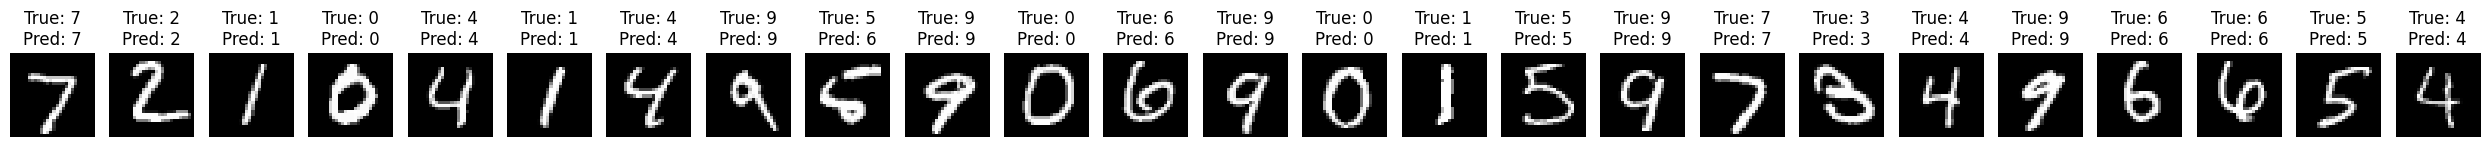


Inference test completed. Predicted vs. True labels for 25 samples displayed.


In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Evaluate the model on the test data
print("\nEvaluating model on test data...")
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Predict a few test images
print("\nMaking predictions on a few test images...")
predictions = model.predict(x_test[:25]) # Predict on the first 5 test images

# Display images and predictions
plt.figure(figsize=(25, 25))
for i in range(25):
    plt.subplot(1, 25, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {np.argmax(y_test[i])}\nPred: {np.argmax(predictions[i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()

print("\nInference test completed. Predicted vs. True labels for 25 samples displayed.")

In [68]:
import os

# Calculate model memory footprint for SiFive FE310-G002
print("\nMemory Analysis for SiFive FE310-G002 Board:")
print("Available Memory:")
print("- Instruction Cache (L1): 16KB")
print("- Data SRAM (L1): 16KB")
print("- ROM: 8KB")
print("- On-board SPI Flash: 32 Mbit")

# Calculate model parameters memory (now using int4 = 0.5 bytes per parameter)
total_params = model.count_params()
weights_memory_bytes = (total_params * 0.5)  # 4 bits per parameter
weights_memory_kb = weights_memory_bytes / 1024

print(f"\nModel Memory Requirements:")
print(f"Total Model Parameters: {total_params}")
print(f"Estimated Memory for Weights (int4): {weights_memory_bytes:.0f} bytes ({weights_memory_kb:.2f} KB)")

# Calculate activation memory for inference
input_mem = 28 * 28 * 1  # Input layer (int8)
flatten_output_mem = 784  # Flattened input (int8)
dense1_output_mem = 8    # Hidden layer output (int8)
dense2_output_mem = 10   # Output layer (int8)

total_activation_mem = input_mem + flatten_output_mem + dense1_output_mem + dense2_output_mem
print(f"Estimated Activation Memory: {total_activation_mem} bytes ({total_activation_mem/1024:.2f} KB)")

# Total memory requirement
total_memory = weights_memory_bytes + total_activation_mem
print(f"Total Memory Requirement: {total_memory:.0f} bytes ({total_memory/1024:.2f} KB)")

# Memory utilization analysis
data_sram_utilization = (total_memory / (16 * 1024)) * 100
print(f"\nData SRAM Utilization: {data_sram_utilization:.1f}% of 16KB")


Memory Analysis for SiFive FE310-G002 Board:
Available Memory:
- Instruction Cache (L1): 16KB
- Data SRAM (L1): 16KB
- ROM: 8KB
- On-board SPI Flash: 32 Mbit

Model Memory Requirements:
Total Model Parameters: 25818
Estimated Memory for Weights (int4): 12909 bytes (12.61 KB)
Estimated Activation Memory: 1586 bytes (1.55 KB)
Total Memory Requirement: 14495 bytes (14.16 KB)

Data SRAM Utilization: 88.5% of 16KB


In [69]:
import numpy as np
import os
import tensorflow as tf

# Save the model in Keras format
keras_model_path = "mnist_baseline_model.keras"
model.save(keras_model_path)
print(f"\nKeras model saved to {keras_model_path}")

# Load the model for conversion
loaded_model = tf.keras.models.load_model(keras_model_path)

# Create TFLite converteconverter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
# Create TFLite converter with INT4 quantization
# Enhanced quantization configuration
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Set target spec for INT4
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
    tf.lite.OpsSet.TFLITE_BUILTINS,
]

# Increase calibration samples
def representative_data_gen():
    num_calibration_samples = 1000  # Increased from 100
    for i in range(num_calibration_samples):
        # Add noise for robustness
        image = x_train[i:i+1].astype(np.float32)
        image += np.random.normal(0, 0.01, image.shape)
        image = np.clip(image, 0, 1)
        yield [image]

converter.representative_dataset = representative_data_gen
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8


# Force 4-bit weights through post-training quantization
converter.target_spec._experimental_low_bit_qat = True
converter.target_spec._experimental_weight_bits = 4

# Convert model to TFLite format
tflite_model_quant = converter.convert()

# Save the quantized model
tflite_model_quant_filename = "mnist_quantized_model.tflite"
with open(tflite_model_quant_filename, "wb") as f:
    f.write(tflite_model_quant)

print(f"\nInt4 quantized TFLite model saved to {tflite_model_quant_filename}")

# Check model size
tflite_model_quant_size_bytes = os.path.getsize(tflite_model_quant_filename)
tflite_model_quant_size_kb = tflite_model_quant_size_bytes / 1024
print(f"Int4 Quantized Model Size: {tflite_model_quant_size_bytes} bytes ({tflite_model_quant_size_kb:.2f} KB)")

# Clean up temporary files
os.remove(keras_model_path)
print(f"Cleaned up temporary Keras model file: {keras_model_path}")

# Create an interpreter to analyze the model
interpreter = tf.lite.Interpreter(model_path=tflite_model_quant_filename)
interpreter.allocate_tensors()

# Get model details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("\nModel Details:")
print("Input:", input_details)
print("Output:", output_details)

# Print quantization parameters
print("\nQuantization Parameters:")
print(f"Input Scale: {input_details[0]['quantization_parameters']['scales']}")
print(f"Input Zero Point: {input_details[0]['quantization_parameters']['zero_points']}")
print(f"Output Scale: {output_details[0]['quantization_parameters']['scales']}")
print(f"Output Zero Point: {output_details[0]['quantization_parameters']['zero_points']}")


Keras model saved to mnist_baseline_model.keras
INFO:tensorflow:Assets written to: C:\Users\shwet\AppData\Local\Temp\tmp1vw0klu7\assets
INFO:tensorflow:Assets written to: C:\Users\shwet\AppData\Local\Temp\tmp1vw0klu7\assets


INFO:tensorflow:Assets written to: C:\Users\shwet\AppData\Local\Temp\tmp1vw0klu7\assets



Int4 quantized TFLite model saved to mnist_quantized_model.tflite
Int4 Quantized Model Size: 28888 bytes (28.21 KB)
Cleaned up temporary Keras model file: mnist_baseline_model.keras

Model Details:
Input: [{'name': 'serving_default_flatten_5_input:0', 'index': 0, 'shape': array([ 1, 28, 28,  1]), 'shape_signature': array([-1, 28, 28,  1]), 'dtype': <class 'numpy.int8'>, 'quantization': (0.003921568859368563, -128), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([-128]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output: [{'name': 'StatefulPartitionedCall:0', 'index': 12, 'shape': array([ 1, 10]), 'shape_signature': array([-1, 10]), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]

Quantization Parameters:
Input Scale: [0.00392157]
Input Zero Point: [-1

c:\Users\shwet\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [70]:
# Generate a .h file for the quantized TFLite model

import os

tflite_model_quant_filename = "mnist_quantized_model.tflite"
c_model_filename = "mnist_model_data.h"

# Read the TFLite model file as bytes
with open(tflite_model_quant_filename, "rb") as f:
    tflite_model_bytes = f.read()

# Convert bytes to a C-style array declaration
# Format: const unsigned char model_name[] = { 0x.., 0x.., ... };
bytes_as_hex = [f"0x{byte:02x}" for byte in tflite_model_bytes]
c_array_declaration = f"const unsigned char {os.path.basename(tflite_model_quant_filename).replace('.', '_')}_data[] = {{\n    "
c_array_declaration += ", ".join(bytes_as_hex)
c_array_declaration += "\n};\n"
c_array_declaration += f"const int {os.path.basename(tflite_model_quant_filename).replace('.', '_')}_len = {len(tflite_model_bytes)};\n"

# Write the C array declaration to the .h file
with open(c_model_filename, "w") as f:
    f.write("#ifndef MNIST_MODEL_DATA_H_\n")
    f.write("#define MNIST_MODEL_DATA_H_\n\n")
    f.write(c_array_declaration)
    f.write("\n#endif // MNIST_MODEL_DATA_H_\n")

print(f"\nC header file generated: {c_model_filename}")
print(f"This file contains the quantized model as a byte array, ready for embedded C inclusion.")


C header file generated: mnist_model_data.h
This file contains the quantized model as a byte array, ready for embedded C inclusion.
